In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

from density import density_profile, parker_critical, mach_parker
from ifront_guess import ionisation_front, ionisation_fraction_error, ionisation_fraction_plot, generate_guess_light, generate_guess_dense
from ifront_guess import scale_height, surface_density, light_or_dense

In [2]:
from astropy.constants import M_sun, R as R_gas, G
k = 1e-2 * u.cm**2/u.g # opacity
alpha_B = 2.6e-13 * (u.cm**3)/u.s # cm3s-1 at (T = 10^4 K) From Owen and Alvarez 2016

## Calculate mass loss rate
The mass loss rate can be found knowing the position of the ionisation front:
$$\dot M = 4\pi R_{IF}^2 c_s M(R_{IF}) \rho(R_{IF})$$

Where $\dot M$ is the mass loss, $R_{IF}$ the position of the ionisation front, $c_s$ the speed of sound, $M(R_{IF})$ the mach number at the ionisation front and $\rho(R_{IF})$ the density at the ionisation front.

In [3]:
def mass_loss_rate(r_I, R_s, M_s, a_H, a_P):
    R_I = r_I*parker_critical(a_P, M_s)
    rho_s = surface_density(a_H, M_s, R_s)
    rho = density_profile(r_I, r_I, R_s, M_s, rho_s, a_H, a_P)
    M_dot = 4*np.pi*(R_I**2)*a_P*mach_parker(r_I)*rho
    #print(a_P.decompose())
    #print(mach_parker(r_I))
    return M_dot

# Parameter List

In [4]:
# Parameter list
T_H = 3500 * u.K # temperature in hydrostatic region
T_P= 1e4 * u.K # temperature in parker wind region

mu_H = 1 * u.g / u.mol # mean molecular weight in units of hydrogen mass
mu_P = mu_H/2

M_BH = 4e6 * M_sun
a_H = np.sqrt(R_gas*T_H/mu_H)
a_P = np.sqrt(R_gas*T_P/mu_P)

In [35]:
N = 5 # number mass points
m_dot_list = np.logspace(-1, 0, 3)[1:2]
mass_list = np.linspace(0.5, 8, N) * u.solMass
d = 0.05 * u.parsec # distance to supermassive black hole
print(m_dot_list)

[0.31622777]


Parametrise radius by escape velocity:
- Find minimum escape velocity (when model breaks down)

$v_e = \sqrt{\frac{2GM}{r}}$, so $r_{min} = \frac{2GM}{v_e^2}$


In [36]:
v_e_max = 92606 * u.m / u.s
radii_list = np.zeros((N, N+1)) * u.astronomical_unit
for i, M_s in enumerate(mass_list):
    r_min = (2*G*M_s/(v_e_max**2)).to(u.astronomical_unit)
    radii_list[i, :] = np.linspace(r_min.value, 4, N+1) * u.astronomical_unit
    print("R_min: ", r_min.value, "R_step: ", (4-r_min.value)/N)

R_min:  0.10344463471709053 R_step:  0.7793110730565819
R_min:  0.49136201490618 R_step:  0.701727597018764
R_min:  0.8792793950952696 R_step:  0.6241441209809461
R_min:  1.267196775284359 R_step:  0.5465606449431283
R_min:  1.6551141554734485 R_step:  0.46897716890531027


# Evaluate over grid

In [39]:
# Calculate ioniastion front for grid
r_I_list = np.zeros((len(mass_list), len(radii_list[0, :]), len(m_dot_list)))
print(r_I_list.shape)
for k, m_dot in enumerate(m_dot_list):
    for i, M_s in enumerate(mass_list):
        for j, R_s in enumerate(radii_list[i, :]):
            try:
                res = ionisation_front(m_dot, M_s, M_BH, R_s, a_H, a_P, d, R_bins = 300)
                r_I_list[i, j, k] = res
                print("* ", i, j, k, res, mass_list[i], radii_list[i, j], m_dot_list[k])
            except ValueError as v:
                print("- ValueError: ", v)
                print("- ", i, j, k, "Fail", mass_list[i], radii_list[i, j], m_dot_list[k])
                break

(5, 6, 1)
*  0 0 0 0.08249480084753318 0.5 solMass 0.10344463471709053 AU 0.31622776601683794
*  0 1 0 1.2086907951995416 0.5 solMass 0.8827557077736724 AU 0.31622776601683794
*  0 2 0 4.286920390066579 0.5 solMass 1.6620667808302543 AU 0.31622776601683794
- ValueError:  f(a) and f(b) must have different signs
-  0 3 0 Fail 0.5 solMass 2.441377853886836 AU 0.31622776601683794
*  1 0 0 0.08226736767287503 2.375 solMass 0.49136201490618 AU 0.31622776601683794
*  1 1 0 0.21902796545782724 2.375 solMass 1.193089611924944 AU 0.31622776601683794
*  1 2 0 0.3841901728516013 2.375 solMass 1.8948172089437079 AU 0.31622776601683794
*  1 3 0 0.5804624520597802 2.375 solMass 2.5965448059624716 AU 0.31622776601683794
*  1 4 0 0.8068370060079464 2.375 solMass 3.298272402981236 AU 0.31622776601683794
*  1 5 0 1.0663066956124512 2.375 solMass 4.0 AU 0.31622776601683794
*  2 0 0 0.08216598350877997 4.25 solMass 0.8792793950952696 AU 0.31622776601683794
*  2 1 0 0.14678510968841535 4.25 solMass 1.503423

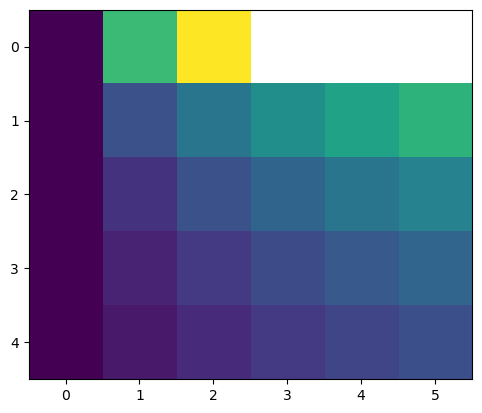

In [40]:
# Plot grid r_I values
plt.imshow(np.log10(r_I_list[:,:,-1]))

In [42]:
# Find mass loss rate over grid
m_loss_list = np.zeros((len(mass_list), len(radii_list[0, :]), len(m_dot_list))) * u.solMass/u.a
for k, m_dot in enumerate(m_dot_list):
    for i, M_s in enumerate(mass_list):
        for j, R_s in enumerate(radii_list[i, :]):
                r_I = r_I_list[i, j, k]
                M_dot = mass_loss_rate(r_I, R_s, M_s, a_H, a_P).decompose()
                m_loss_list[i, j, k] = M_dot.to(u.solMass/u.a)

/Users/jacopouggeri/workspace/photoev/density.py:44: RuntimeWarning: invalid value encountered in double_scalars
  arg = -(ratio)**4 * np.exp(3 - 4*ratio)
/Users/jacopouggeri/workspace/photoev/density.py:87: RuntimeWarning: invalid value encountered in double_scalars
  return ((r_I/r)**2) * rho_p * m_ratio


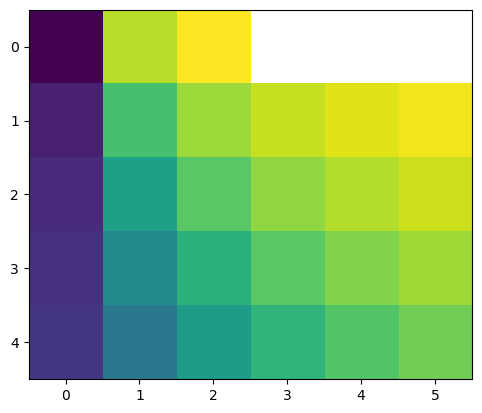

In [44]:
plt.imshow(np.log10(m_loss_list[:,:,0].value))

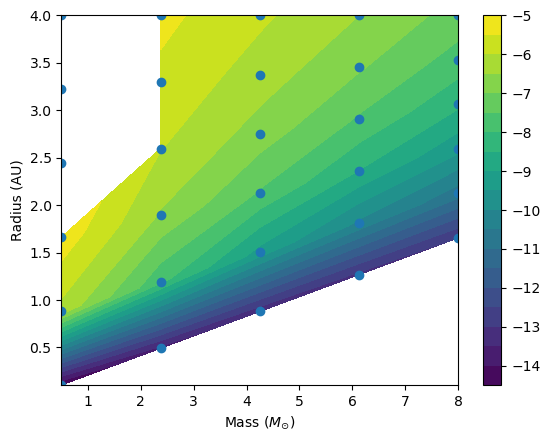

In [49]:
from matplotlib import cm, colors, ticker
X = np.tensordot(mass_list, np.ones(N + 1), axes=0).value
Y = radii_list.to(u.astronomical_unit).value
Z = m_loss_list[:, :, 0].to(u.solMass/u.a).value

plt.xlabel(r"Mass $(M_{\odot}$)")
plt.ylabel("Radius (AU)")
plt.contourf(X, Y, np.log10(Z), 20)
plt.colorbar()
plt.scatter(X, Y)

In [52]:
# Find mass loss rate over grid
v_esc_list = np.zeros((len(mass_list), len(radii_list[:, 0]), len(m_dot_list))) * u.m/u.s
for i, M_s in enumerate(mass_list):
    for j, R_s in enumerate(radii_list[:, i]):
        v_esc_list[i, j] = np.sqrt(2*G*M_s/R_s).decompose()

[[[92606.        ]
  [42490.54690163]
  [31763.59595141]
  [26458.85714286]
  [23151.5       ]]

 [[69090.70888104]
  [59429.6788794 ]
  [52941.86621943]
  [48200.36363891]
  [44540.3190097 ]]

 [[67356.31807045]
  [63083.95505552]
  [59533.4274036 ]
  [56521.97240144]
  [53925.67371936]]

 [[66718.0977003 ]
  [64693.88686986]
  [62843.40174009]
  [61143.13460014]
  [59573.80286509]]

 [[66386.33791924]
  [65600.9066725 ]
  [64842.70944829]
  [64110.20792011]
  [63401.98272633]]] m / s


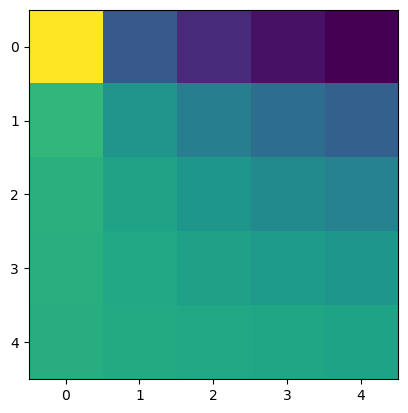

In [53]:
plt.imshow(v_esc_list)
print(v_esc_list)

In [55]:
pos = np.where(m_loss_list == np.nanmin(m_loss_list[:10,:]))
mass_min = mass_list[pos[0]]
radius_min = radii_list[pos[1]]
print(pos, mass_min, radius_min)
print(np.sqrt(2*G*mass_min/radius_min).decompose())

(array([0]), array([0]), array([0])) [0.5] solMass [[0.10344463 0.88275571 1.66206678 2.44137785 3.22068893 4.        ]] AU
[[92606.         31700.99136316 23103.02649898 19062.31362866
  16596.58447981 14892.34591484]] m / s


In [16]:
import os
def new_fname(name, path="data", form="txt"):
    """Generate file name not present in the directory from given string.

    Parameters
    ----------
    name : str
        proposed file name
    path : str, optional
        directory in which the file will be saved, use empty string for current directory, by default "data"
    form : str, optional
        format of file, eg. "txt" or "npy"
    """
    # Folder path where the files are located
    folder_path = "data"

    # Desired file name
    file_name = name
    current_file_name = file_name + "." + form
    current_file_path = os.path.join(folder_path, current_file_name)

    # Initialize the file number
    file_num = 1

    # Check if file name already exists in the folder
    while True:
        current_file_name = file_name + str(file_num) + "." + form
        current_file_path = os.path.join(folder_path, current_file_name)
        if os.path.exists(current_file_path):
            file_num += 1
        else:
            break

    return current_file_path

In [17]:
# Save data in files
np.savetxt(new_fname("mass_list"), mass_list.to(u.solMass).value) # In solar masses
np.savetxt(new_fname("radii_list"), radii_list.to(u.astronomical_unit).value) # In astronomical units
np.savetxt(new_fname("m_dot_list"), m_dot_list)
# 3D arrays in npy format
np.save(new_fname("r_I_list", form="npy"), r_I_list)
np.save(new_fname("m_loss_list", form="npy"), m_loss_list.to(u.solMass/u.a).value) # In solar masses per year



In [18]:
params = {
    'T_H': T_H,
    'T_P': T_P,
    'mu_H': mu_H,
    'mu_P': mu_P,
    'M_BH': M_BH,
    'd': d
}
print(params)
np.save(new_fname("params", form="npy"), params)

{'T_H': <Quantity 3500. K>, 'T_P': <Quantity 10000. K>, 'mu_H': <Quantity 1. g / mol>, 'mu_P': <Quantity 0.5 g / mol>, 'M_BH': <Quantity 7.95363948e+36 kg>, 'd': <Quantity 0.05 pc>}


### Resolution check
Radial bins for integration go up to $10R_c$, check that bin number contain at least 3 bins per scale height

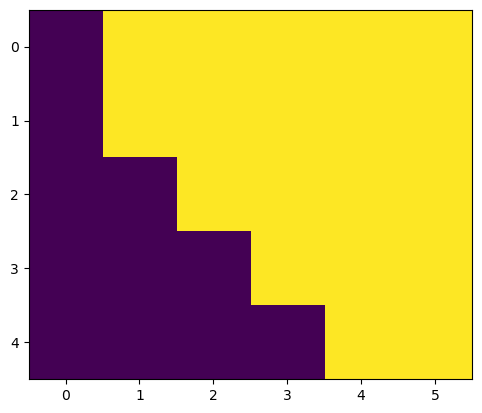

In [64]:
R_bins = 300
arr = np.zeros((len(mass_list), len(radii_list[0, :])))

for i, M_s in enumerate(mass_list):
    R_c = parker_critical(a_P, M_s)
    for j, R_s in enumerate(radii_list[i, :]):
        H = a_P**2/(G*M_s/R_s**2) # scale height
        arr[i, j] = 10*R_c/R_bins < 3*H

plt.imshow(arr)

In [88]:
# Find necessary bin sizes
bin_sizes = np.zeros((len(mass_list), len(radii_list[0, :])))
for i, M_s in enumerate(mass_list):
    R_c = parker_critical(a_P, M_s)
    for j, R_s in enumerate(radii_list[i, :]):
        H = a_P**2/(G*M_s/R_s**2) # scale height
        right_R_bins = int((10*R_c)/(3*H) + 200)
        bin_sizes[i, j] = right_R_bins
        print(right_R_bins, 10*R_c/right_R_bins < 3*H)

1308 True
215 True
204 True
201 True
201 True
200 True
1308 True
387 True
274 True
239 True
224 True
216 True
1308 True
579 True
389 True
313 True
275 True
253 True
1308 True
740 True
519 True
410 True
349 True
311 True
1308 True
872 True
651 True
523 True
443 True
389 True


In [95]:
print(bin_sizes)

[[1308.  215.  204.  201.  201.  200.]
 [1308.  387.  274.  239.  224.  216.]
 [1308.  579.  389.  313.  275.  253.]
 [1308.  740.  519.  410.  349.  311.]
 [1308.  872.  651.  523.  443.  389.]]
